# Feature Engineering
## 1. Imports

In [ ]:
pip install googletrans==3.1.0a0

In [ ]:
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from googletrans import Translator
from collections import Counter


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## 2. Dataset load

In [ ]:
# read the training file and extract genre and plot

input_file = '/content/sample_data/train.txt'

genres = []
plots = []

with open(input_file, 'r', encoding='utf-8') as infile:
    for line in infile:
        # Split the line by tabs
        parts = line.split('\t')

        # Extract genre and plot
        genres.append(parts[2])
        plots.append(parts[4])


A saída de streaming foi truncada nas últimas 5000 linhas.
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3

# 3. Train test split and Data augmentation

In [ ]:
X_train, X_test, Z_train, Z_test = train_test_split(plots, genres, test_size=0.1, random_state=33)

translator = Translator()
aug_X_train = []
aug_Z_train = []
drama_counter = 0

for i in range(len(X_train)):

        # Split the line by tabs

        if Z_train[i] == 'sci-fi':
            # Perform back translation
            translated = translator.translate(X_train[i], src='en', dest='es').text
            back_translated = translator.translate(translated, src='es', dest='en').text

            # Perform synonym replacement
            translated2 = translator.translate(X_train[i], src='en', dest='fr').text
            back_translated2 = translator.translate(translated2, src='fr', dest='en').text

            # Append plots
            aug_X_train.append(X_train[i])
            aug_Z_train.append(Z_train[i])
            aug_X_train.append(translated)
            aug_Z_train.append(Z_train[i])
            aug_X_train.append(translated2)
            aug_Z_train.append(Z_train[i])


        elif Z_train[i] in {'crime', 'animation'}:
            # Perform back translation
            translated = translator.translate(X_train[i], src='en', dest='es').text
            back_translated = translator.translate(translated, src='es', dest='en').text

            # Append both plots to the specified file
            aug_X_train.append(X_train[i])
            aug_Z_train.append(Z_train[i])
            aug_X_train.append(translated)
            aug_Z_train.append(Z_train[i])


        elif (Z_train[i] == 'drama'):
            if (drama_counter < 1000):
                drama_counter += 1
                aug_X_train.append(X_train[i])
                aug_Z_train.append(Z_train[i])

        else:
            aug_X_train.append(X_train[i])
            aug_Z_train.append(Z_train[i])

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200


# 4. Pre-Processing

In [ ]:
#porter_stemmer=PorterStemmer()
lemmatizer = WordNetLemmatizer()

#Function to get WordNet POS tag
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if no tag match

#Function to lemmatize sentence with POS tagging
def processSentence(s):
    words = re.split("\s+", s.lower())  # Lowercasing and tokenizing
    pos_tags = nltk.pos_tag(words)  # Get POS tags for each word
    lemmed_words = [lemmatizer.lemmatize(w, get_wordnet_pos(pos)) for w, pos in pos_tags]
    return ' '.join(lemmed_words)

def filter_stopwords(tokens):
    aux = [word for word in tokens if word.isalpha() and word not in stop_words] # watch out for isalpha()
    return ' '.join(aux)

#lemmatization and Lowercasing
lemmed_train_plots = [processSentence(plot) for plot in aug_X_train]
lemmed_test_plots = [processSentence(plot) for plot in X_test]
lemmed_og_train_plots = [processSentence(plot) for plot in X_train]


#Tokenizing
tokenized_train_plots = [nltk.wordpunct_tokenize(sp) for sp in lemmed_train_plots]
tokenized_test_plots = [nltk.wordpunct_tokenize(sp) for sp in lemmed_test_plots]
tokenized_og_train_plots = [nltk.wordpunct_tokenize(sp) for sp in lemmed_og_train_plots]

stop_words = set(stopwords.words('english'))

filtered_train_plots = [filter_stopwords(tp) for tp in tokenized_train_plots]
filtered_test_plots = [filter_stopwords(tp) for tp in tokenized_test_plots]
filtered_og_train_plots = [filter_stopwords(tp) for tp in tokenized_og_train_plots]



# 5. Train Test Split

==== Original Dataset ====
==== MultinomialNB ====
Resultados com tfidf
              precision    recall  f1-score   support

      action       0.77      0.32      0.45       113
   animation       1.00      0.22      0.36        60
      comedy       0.80      0.10      0.18       119
       crime       1.00      0.00      0.00        57
       drama       0.28      0.98      0.44       165
      horror       0.75      0.70      0.72       101
     romance       0.82      0.15      0.25        95
      sci-fi       1.00      0.00      0.00        19
     western       0.98      0.62      0.76        76

    accuracy                           0.44       805
   macro avg       0.82      0.34      0.35       805
weighted avg       0.74      0.44      0.40       805



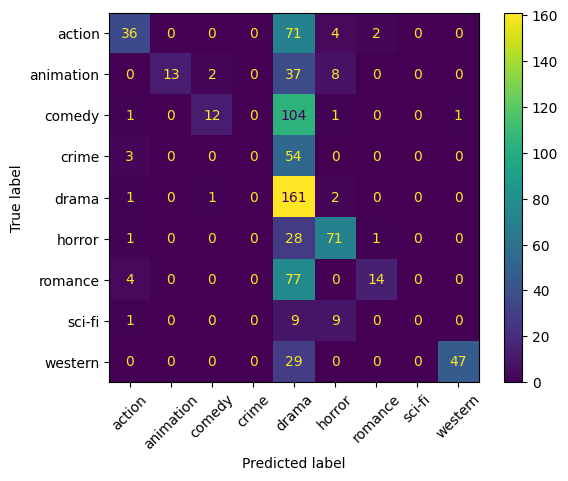

==== SVM ====
Resultados com tfidf
              precision    recall  f1-score   support

      action       0.60      0.67      0.63       113
   animation       0.79      0.62      0.69        60
      comedy       0.60      0.61      0.61       119
       crime       0.57      0.42      0.48        57
       drama       0.56      0.61      0.58       165
      horror       0.81      0.86      0.84       101
     romance       0.55      0.49      0.52        95
      sci-fi       0.58      0.58      0.58        19
     western       0.86      0.91      0.88        76

    accuracy                           0.65       805
   macro avg       0.66      0.64      0.65       805
weighted avg       0.65      0.65      0.65       805



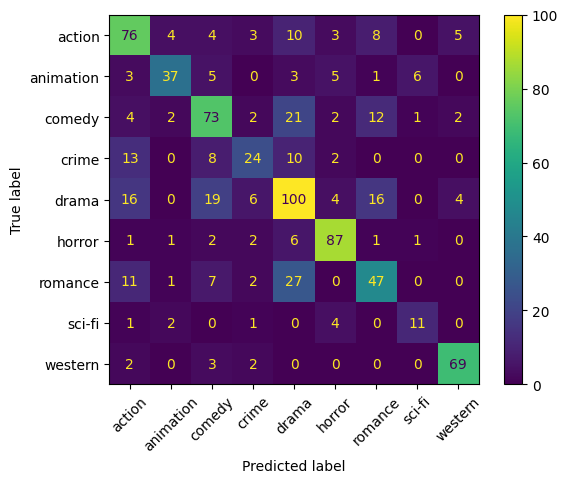

==== Augmented Dataset ====
==== MultinomialNB ====
Resultados com tfidf
              precision    recall  f1-score   support

      action       0.59      0.66      0.62       113
   animation       1.00      0.23      0.38        60
      comedy       0.39      0.76      0.52       119
       crime       1.00      0.04      0.07        57
       drama       0.54      0.34      0.42       165
      horror       0.42      0.94      0.58       101
     romance       0.75      0.35      0.47        95
      sci-fi       1.00      0.00      0.00        19
     western       0.98      0.78      0.87        76

    accuracy                           0.53       805
   macro avg       0.74      0.46      0.44       805
weighted avg       0.66      0.53      0.49       805



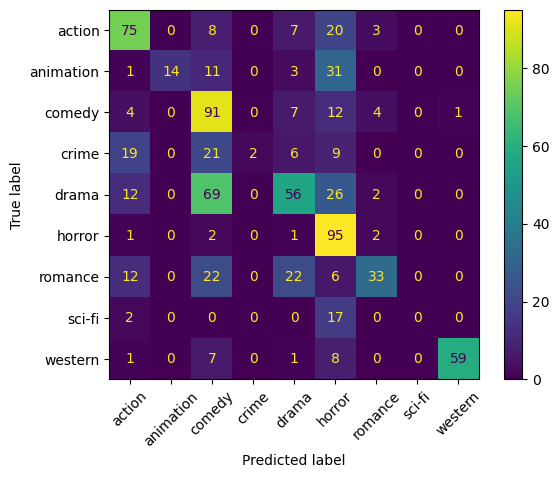

==== SVM ====
Resultados com tfidf
              precision    recall  f1-score   support

      action       0.57      0.70      0.63       113
   animation       0.90      0.60      0.72        60
      comedy       0.55      0.68      0.61       119
       crime       0.58      0.44      0.50        57
       drama       0.57      0.44      0.50       165
      horror       0.79      0.87      0.83       101
     romance       0.52      0.56      0.54        95
      sci-fi       0.57      0.42      0.48        19
     western       0.85      0.92      0.89        76

    accuracy                           0.64       805
   macro avg       0.66      0.63      0.63       805
weighted avg       0.64      0.64      0.63       805



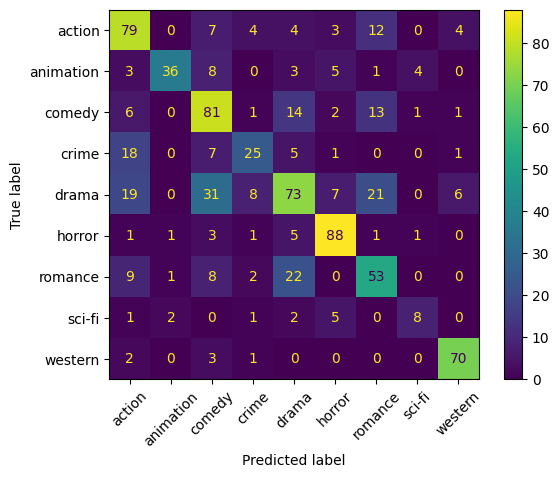

In [ ]:
labels = np.unique(genres).tolist()
index = np.arange(len(labels))

train_vectorizer = TfidfVectorizer(min_df = 2)

print("==== Original Dataset ====")

X_train_tfidf = train_vectorizer.fit_transform(filtered_og_train_plots).toarray()
X_test_tfidf = train_vectorizer.transform(filtered_test_plots).toarray()

print("==== MultinomialNB ====")
og_nb = MultinomialNB()

print("Resultados com tfidf")
og_nb.fit(X_train_tfidf, Z_train)
x_pred=og_nb.predict(X_test_tfidf)
print(classification_report(y_pred=x_pred, y_true=Z_test, labels = labels, zero_division=1.))
cm = confusion_matrix(y_pred=x_pred, y_true=Z_test, labels=labels)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot()
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()


print("==== SVM ====")
og_svm = svm.LinearSVC()

print("Resultados com tfidf")
og_svm.fit(X_train_tfidf, Z_train)
x_pred=og_svm.predict(X_test_tfidf)
print(classification_report(y_pred=x_pred, y_true=Z_test, labels = labels, zero_division=1.))
cm = confusion_matrix(y_pred=x_pred, y_true=Z_test, labels=labels)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot()
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()


print("==== Augmented Dataset ====")

X_train_tfidf = train_vectorizer.fit_transform(filtered_train_plots).toarray()
X_test_tfidf = train_vectorizer.transform(filtered_test_plots).toarray()

print("==== MultinomialNB ====")
aug_nb = MultinomialNB()

print("Resultados com tfidf")
aug_nb.fit(X_train_tfidf, aug_Z_train)
x_pred=aug_nb.predict(X_test_tfidf)
print(classification_report(y_pred=x_pred, y_true = Z_test, labels = labels, zero_division=1.))
cm = confusion_matrix(y_pred=x_pred, y_true=Z_test, labels=labels)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot()
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

print("==== SVM ====")
aug_svm = svm.LinearSVC()

print("Resultados com tfidf")
aug_svm.fit(X_train_tfidf, aug_Z_train)
x_pred=aug_svm.predict(X_test_tfidf)
print(classification_report(y_pred=x_pred, y_true=Z_test, labels = labels, zero_division=1.))
cm = confusion_matrix(y_pred=x_pred, y_true=Z_test, labels=labels)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot()
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()



# 6. Balance Test

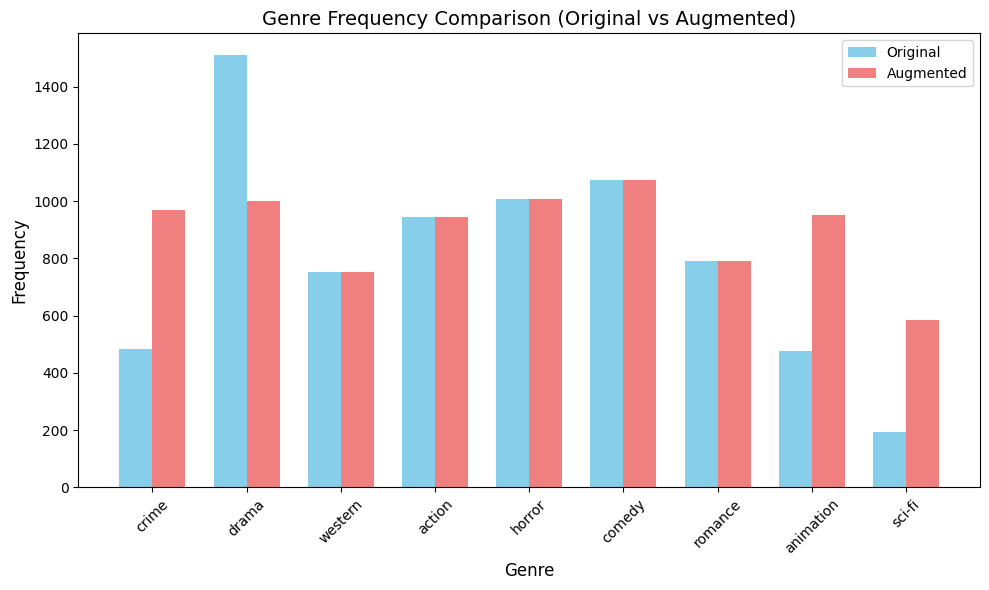

In [ ]:
# Count the frequency of each genre using Counter for both datasets
aug_genre_counts = Counter(aug_Z_train)
genre_counts = Counter(Z_train)

# Extract genre names and their respective counts (ensure genres are aligned)
labels = list(genre_counts.keys())
aug_counts = list(aug_genre_counts.values())
counts = list(genre_counts.values())

# Set width of bars and positions
bar_width = 0.35
index = np.arange(len(labels))

# Create a bar plot with two bars per genre
plt.figure(figsize=(10, 6))
plt.bar(index, counts, bar_width, label='Original', color='skyblue')
plt.bar(index + bar_width, aug_counts, bar_width, label='Augmented', color='lightcoral')

# Add titles and labels
plt.title('Genre Frequency Comparison (Original vs Augmented)', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(index + bar_width / 2, labels, rotation=45)  # Rotate labels for better readability
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# 7. Label Fitting


In [52]:
# read the test_no_labels.txt file and extract plots

input_file = '/content/sample_data/test_no_labels.txt'
output_file = '/content/sample_data/results.txt'

eval_plots = []

with open(input_file, 'r', encoding='utf-8') as infile:
    for line in infile:
        # Split the line by tabs
        parts = line.split('\t')

        # Extract plots
        eval_plots.append(parts[3])


#lemmatization and Lowercasing
lemmed_eval_plots = [processSentence(plot) for plot in eval_plots]

#Tokenizing
tokenized_eval_plots = [nltk.wordpunct_tokenize(sp) for sp in lemmed_eval_plots]

#Filtering Stopwords
filtered_eval_plots = [filter_stopwords(tp) for tp in tokenized_eval_plots]


X_eval_tfidf = train_vectorizer.transform(filtered_eval_plots).toarray()

eval_pred = aug_svm.predict(X_eval_tfidf)

with open(output_file, 'w', encoding='utf-8') as infile:
    for pred in eval_pred:
      infile.write(pred + '\n')




